⚠️ **Static Version Notice**

This is a static export of an interactive marimo notebook. Some features have been modified for compatibility:

- Interactive UI elements (sliders, dropdowns, text inputs) have been removed
- UI variable references have been replaced with default values
- Some cells may have been simplified or removed entirely

For the full interactive experience, please run the original marimo notebook (.py file) using:
```bash
uv run marimo edit notebook_name.py
```

---


In [53]:
EPOCHS = 10


# Module 4: Practical 3 - Convolutional Neural Networks

In this practical, we "upgrade" our Fully Connected Neural Network to a Convolutional Neural Network (CNN). Except for the model definition, most of the code here is identical to Practical 1.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)

# Check which GPU is available
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

print(f"Using device: {device}")


Using device: mps


In [55]:
BATCH_SIZE = 32

# Prepare the Data
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)


In [56]:
train_dataset[0][0].shape


torch.Size([3, 32, 32])

Label:  6


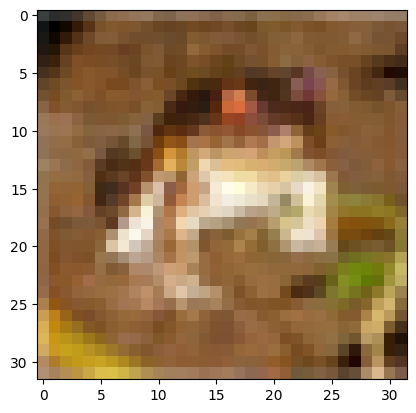

In [57]:
first_img, first_label = train_dataset[0]
print("Label: ", first_label)
plt.imshow(first_img.permute(1, 2, 0).squeeze())
plt.show()


In [58]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)
CLASSES[first_label]


np.str_('frog')

In [59]:
print("Some individual pixel: ", train_dataset[54][0][1, 12, 13])
print("Corresponding Label: ", train_dataset[54][1])


Some individual pixel:  tensor(0.3686)
Corresponding Label:  2


Label:  8 ship


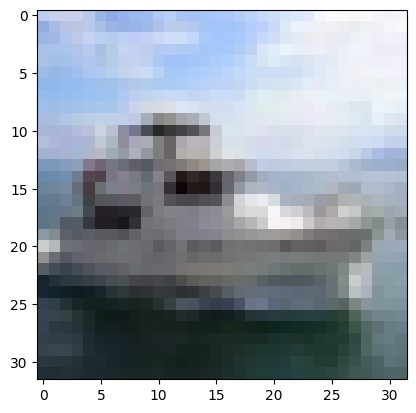

In [60]:
_random_index = np.random.randint(len(train_dataset))
_img, _label = train_dataset[_random_index]
print("Label: ", _label, CLASSES[_label])
plt.imshow(_img.permute(1, 2, 0).squeeze())
plt.show()


In [61]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [62]:
print("Length of the train dataset: ", len(train_dataset))
print("Length of list(train_loader): ", len(list(train_loader)))
print(
    "Shape of the first element of list(train_loader)[0]: ",
    list(train_loader)[0][0].shape,
)


Length of the train dataset:  50000
Length of list(train_loader):  1563
Shape of the first element of list(train_loader)[0]:  torch.Size([32, 3, 32, 32])


**Dataloaders** provide multiple ways to access the data, either by converting it into a **Python list** or by using an **iterable**.

Using `list(train_loader)`, as we have shown in Practical 1, loads the **entire dataset into memory**, which can be **slow** and even **fail** when dealing with large datasets.

Since **neural network training algorithms process data in batches**, it is more efficient to use an **iterator**. Instead of retrieving the first batch like this:
```python
list(train_loader)[0]
```
which loads everything into memory, we use:
```python
next(iter(train_loader))
```
This approach retrieves only the first batch without loading the entire dataset, making it memory-efficient and faster.

Let's load the first batch of our data (image and label) and display it using the `matplotlib` library.

Recall that the shape returned by
```python
next(iter(train_loader))
```
is 32 by 3 by 32 by 32. This shape represents the batch size, number of channels, height, and width of the image, respectively.

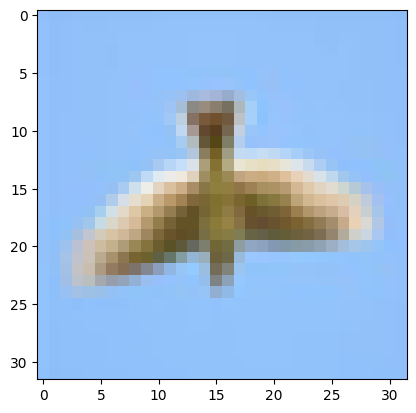

Label:  bird


In [63]:
next_batch_images, next_batch_labels = next(iter(train_loader))
_first_img = next_batch_images[0]  # retrieve the first image from the batch of 32
_first_label = next_batch_labels[0]  # retrieve the first label from the batch of 32
plt.imshow(
    _first_img.permute(1, 2, 0)
)  # imshow requires the image to be in height x width x channels format
plt.show()
print("Label: ", CLASSES[_first_label])


We now define our first CNN architecture. We will use this building block throughout the semester, so make sure you understand how it works. In particular, if we use the same padding and kernel (filter) size values for for both the width and height dimensions, the formula for the image size after the convolution or a max pooling layer is given by:

$$
\frac{width + 2 * padding - (kernelsize -1) - 1}{S} + 1
$$

Verify this with `torch.nn.Conv2d` and `torch.nn.MaxPool2d` function documentation.

In [64]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            3, 16, kernel_size=3, padding=1
        )  # Input channels = 3, Output channels = 16
        self.pool = nn.MaxPool2d(
            kernel_size=2, stride=2
        )  # Pooling layer, will half the dimensions
        self.conv2 = nn.Conv2d(
            16, 32, kernel_size=3, padding=1
        )  # Input channels = 16, Output channels = 32
        self.fc1 = nn.Linear(32 * 8 * 8, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [65]:
net = SimpleCNN()


We can improve the architecture by adding two more common operations: Batch Normalization and Dropout.

- Batch Normalization (BatchNorm) is a technique that normalizes the inputs of each layer across a mini-batch to have zero mean and unit variance, then scales and shifts them with learnable parameters. It stabilizes and speeds up training by reducing internal covariate shift.

- Dropout is a regularization method where, during training, a random fraction of neurons are “dropped” (set to zero) in each forward pass, preventing co-adaptation of features and reducing overfitting.

In [66]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        # Convolutional Layer 1 with BatchNorm
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 2 with BatchNorm
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization after Conv2

        # Third convolutional layer
        self.conv3 = nn.Conv2d(
            32, 64, kernel_size=3, padding=1
        )  # Output channels = 64
        self.bn3 = nn.BatchNorm2d(64)  # Batch Normalization after Conv3

        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(
            64, 128, kernel_size=3, padding=1
        )  # Output channels = 128
        self.bn4 = nn.BatchNorm2d(128)  # Batch Normalization after Conv4

        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Conf and pooling layers
        x = self.pool(
            F.relu(self.bn1(self.conv1(x)))
        )  # Conv -> BatchNorm -> ReLU -> Pool
        x = self.pool(
            F.relu(self.bn2(self.conv2(x)))
        )  # Conv -> BatchNorm -> ReLU -> Pool
        x = self.pool(
            F.relu(self.bn3(self.conv3(x)))
        )  # Conv -> BatchNorm -> ReLU -> Pool
        x = self.pool(
            F.relu(self.bn4(self.conv4(x)))
        )  # Conv -> BatchNorm -> ReLU -> Pool

        # Flatten the feature map
        x = x.view(-1, 128 * 2 * 2)

        # Fully connected layer 1 with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        # Fully connected layer 2 (output)
        x = self.fc2(x)
        return x



In [67]:
model = EnhancedCNN().to(device)
print(model)


EnhancedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Training the model

The training is exactly the same as for our Fully Connected Neural Network.

In [68]:
import altair as alt
from mofresh import refresh_matplotlib, ImageRefreshWidget
import polars as pl

widget = ImageRefreshWidget(src="")

@refresh_matplotlib
def losschart(data):
    df = pl.DataFrame(data)
    plt.plot(df["epoch"], df["train_loss"])
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

widget


ImageRefreshWidget()

In [69]:
from tqdm import tqdm

datalogs = []

# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

for epoch in range(EPOCHS):
    running_loss = 0.0
    running_correct, running_total = 0, 0

    model.train()
    train_loader_with_progress = tqdm(
        iterable=train_loader, ncols=120, desc=f"Epoch {epoch+1}/{EPOCHS}"
    )
    for batch_number, (inputs, labels) in enumerate(train_loader_with_progress):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # predicted = torch.argmax(outputs.data)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # log data for tracking
        running_correct += (predicted == labels).sum().item()
        running_total += labels.size(0)
        running_loss += loss.item()

        if batch_number % 100 == 99:
            train_loader_with_progress.set_postfix(
                {
                    "avg accuracy": f"{running_correct/running_total:.3f}",
                    "avg loss": f"{running_loss/(batch_number+1):.4f}",
                }
            )

            datalogs.append(
                {
                    "epoch": epoch + batch_number / len(train_loader),
                    "train_loss": running_loss / (batch_number + 1),
                    "train_accuracy": running_correct / running_total,
                }
            )

    datalogs.append(
        {
            "epoch": epoch + 1,
            "train_loss": running_loss / len(train_loader),
            "train_accuracy": running_correct / running_total,
        }
    )

    widget.src = losschart(datalogs)

print("Finished Training")


Epoch 3/10:  83%|████████████████████████▊     | 1294/1563 [00:17<00:03, 75.24it/s, avg accuracy=0.670, avg loss=0.9484]


KeyboardInterrupt: 

In [70]:
# Evaluation
test_correct = 0
test_total = 0
model.eval()
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_images)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Accuracy of the network on the 10000 test images: {test_accuracy:.2f}%")


Accuracy of the network on the 10000 test images: 68.62%


In [71]:
print(rf"""The model has an **{test_accuracy:.2f}%** on the test set, much better than the accuracy we got from a fully connected network and due to parameter sharing of convolutional layers the CNN we constructed has less parameters!""")


The model has an **68.62%** on the test set, much better than the accuracy we got from a fully connected network and due to parameter sharing of convolutional layers the CNN we constructed has less parameters!


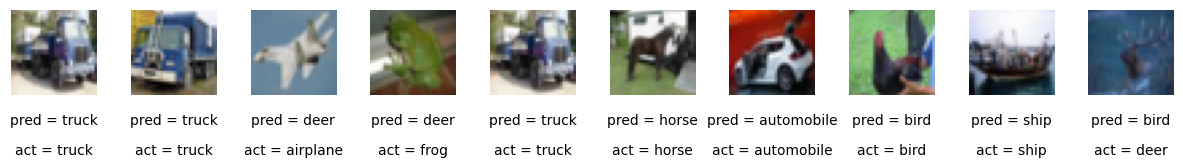

In [72]:
_images, _labels = next(iter(test_loader))
_images = _images.to(device)
_labels = _labels.to(device)
_outputs = model(_images).to(device)
_, preds = torch.max(_outputs, 1)
preds_single = CLASSES[preds.cpu().numpy()]
actual_single = CLASSES[_labels.cpu().numpy()]
n_to_show = 10
indices = np.random.choice(range(len(_images)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for _i, idx in enumerate(indices):
    img = _images[idx].cpu().numpy().transpose((1, 2, 0))
    ax = fig.add_subplot(1, n_to_show, _i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)
plt.show()
